In [2]:
import sys
import os
root_dir = os.getcwd().replace('/notebooks','')
sys.path.insert(1, root_dir)
import pandas as pd
from datetime import datetime as dt
import glob
from modules.utils import *
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar
import os
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
from zipline.data.bundles import register, unregister
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar
from exchange_calendars.exchange_calendar_xdse import XDSExchangeCalendar
from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, 
                     INFO, WARNING, DEBUG, ERROR)
from zipline.api import (order, 
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, symbol
from pyfolio.utils import extract_rets_pos_txn_from_zipline
import pyfolio as pf
import seaborn as sns

In [3]:
# !conda install -c conda-forge ipympl
# !conda install -c conda-forge nodejs
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
# !jupyter lab build
# !pip install ipywidgets
# !pip install ipympl
# ! jupyter nbextension enable --py --sys-prefix widgetsnbextension
# ! jupyter nbextension install --py --symlink --sys-prefix ipympl
# ! jupyter nbextension enable ipympl --py --sys-prefix
%matplotlib widget
import matplotlib.pyplot as plt

In [4]:
# Importing DSE data
repo_dir = os.path.join(os.path.expanduser('~'), 'trading/zipline-technical-analysis/data/dse/')
register_calendar("XDSE", XDSExchangeCalendar())
register("dsebundle", csvdir_equities(["daily"], repo_dir), calendar_name="XDSE")
bundle = 'dsebundle'
calendar_name = 'XDSE'
calendar = get_calendar(calendar_name)
bundle_data = bundles.load(bundle)

In [5]:
top_stocks = pd.read_csv(repo_dir + 'top_stocks.csv')
preferred = top_stocks.Name.loc[top_stocks["Annualized Vol"] < 1].iloc[:10]
prefs = [y for x,y in preferred.items()]
prefs

['BEXIMCO',
 'SQURPHARMA',
 'PTL',
 'SAIFPOWER',
 'FORTUNE',
 'SHAHJABANK',
 'DSSL',
 'BRACBANK',
 'CITYBANK',
 'DOREENPWR']

## Importing strategy and stats

In [6]:
%load_ext autoreload

In [7]:
%autoreload 2
import strategy.moving_average as ma
import strategy.MACD as macd
import strategy.keltner as keltner
import modules.stats_main as stat
from strategy.utils import *

In [9]:
%%capture kltr
start = '2008-01-01'
end = '2022-01-01'
capital_base = 10000
calendar = get_calendar('XDSE')
symb = 'BEXIMCO'
window = 90

def initialize(context):
            context.i = 0
            #set_benchmark(symbol(symb))
            sids = bundle_data.asset_finder.sids
            context.assets = bundle_data.asset_finder.retrieve_all(sids)
            context.signals = {}
            for asset in context.assets:
                if asset.symbol in prefs:
                    # # signal_generator(asset.symbol, keltner_window=window, ma_long=40, ma_short=4, ad_window=4, rsitype=1, downmult=0.8, upmult=0.8, gradient_window=30)
                    # slist = signal_generator(asset.symbol, rsitype=3, keltner_window=90, ma_long=40, ma_short=4, ad_window=10)
                    # signals = slist[['keltner', 'RSI', 'gradient']].sum(axis=1)
                    # buys = [signals[i] if (signals[i]>1) and (slist.ER[i]<0.4) else 0 for i in range(len(signals))]
                    # sells = [signals[i] if (signals[i]<-1) and (slist.ER[i]>0) else 0 for i in range(len(signals))]
                    # context.signals[asset.symbol] = pd.Series([b+s for b,s in zip(buys,sells)], index=slist.index)
                    # macd_signals(df, short_period, long_period, signal_period)
                    context.signals[asset.symbol] = macd.macd_signals(asset_df(asset.symbol), 2, 10, 4)
            context.i = 0

def handle_data(context, data):
    # Skip first 300 days to get full windows
    context.i += 1
    if context.i < window+1:
        return

    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    #cash = min(context.portfolio.cash, 20000)
    current_date = data.history(context.assets[0], 'price', bar_count=2, frequency="1d").index[-1]
    for asset in context.assets:
        if asset.symbol in prefs:
            if data.can_trade(asset) and not get_open_orders(asset):
                cash = context.portfolio.cash
                price = data.current(asset, "price")
                # Find corresponding signal
                #open_orders = get_open_orders()
                if context.signals[asset.symbol][current_date]>=1:
                    # 1 signal means upward trend
                    order_target_percent(asset, 0.1)
                elif context.signals[asset.symbol][current_date]<=-1:
                    # Assume downward trend and sell off
                    order_target(asset, 0)
                else:
                    pass


    
    

result = run_algorithm(start=pd.Timestamp(start, tz='utc'),
                        end=pd.Timestamp(end, tz='utc'),
                        initialize=initialize,
                        handle_data=handle_data,
                        capital_base=capital_base,
                        trading_calendar=calendar,
                        bundle='dsebundle',
                        data_frequency='daily',
                        )

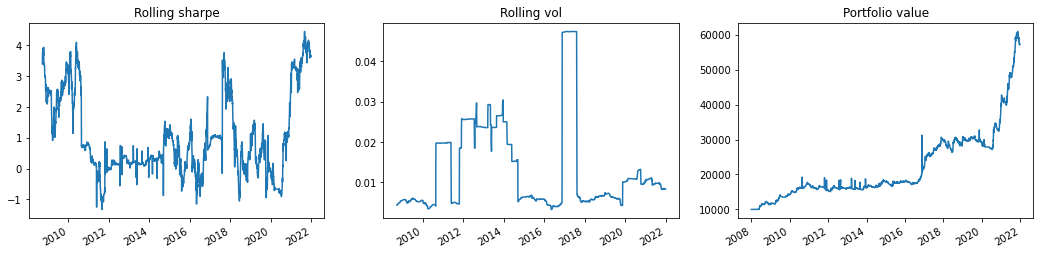

In [12]:
pref_result = stat.show_rolling_stats(result, 180)

# Brute force to find MACD params

In [13]:
%%capture kltr
start = '2008-01-01'
end = '2022-01-01'
capital_base = 10000
calendar = get_calendar('XDSE')
symb = 'BEXIMCO'
window = 90
res_dict={}
        
for short_window in range(2, 6, 2):
    for long_window in range(4, 12, 2):
        for signal_window in range(9, 19, 9):

            def initialize(context):
                context.i = 0
                #set_benchmark(symbol(symb))
                sids = bundle_data.asset_finder.sids
                context.assets = bundle_data.asset_finder.retrieve_all(sids)
                context.signals = {}
                for asset in context.assets:
                    if asset.symbol in prefs:
                        context.signals[asset.symbol] = macd.macd_signals(asset_df(asset.symbol), short_window, long_window, signal_window)
                context.i = 0

            def handle_data(context, data):
                # Skip first 300 days to get full windows
                context.i += 1
                if context.i < window+1:
                    return

                # Compute averages
                # data.history() has to be called with the same params
                # from above and returns a pandas dataframe.
                #cash = min(context.portfolio.cash, 20000)
                current_date = data.history(context.assets[0], 'price', bar_count=2, frequency="1d").index[-1]
                for asset in context.assets:
                    if asset.symbol in prefs:
                        if data.can_trade(asset) and not get_open_orders(asset):
                            cash = context.portfolio.cash
                            price = data.current(asset, "price")
                            # Find corresponding signal
                            #open_orders = get_open_orders()
                            if context.signals[asset.symbol][current_date]>=1:
                                # 1 signal means upward trend
                                order_target_percent(asset, 0.1)
                            elif context.signals[asset.symbol][current_date]<=-1:
                                # Assume downward trend and sell off
                                order_target(asset, 0)
                            else:
                                pass



            result = run_algorithm(start=pd.Timestamp(start, tz='utc'),
                                    end=pd.Timestamp(end, tz='utc'),
                                    initialize=initialize,
                                    handle_data=handle_data,
                                    capital_base=capital_base,
                                    trading_calendar=calendar,
                                    bundle='dsebundle',
                                    data_frequency='daily',
                                    )
            res, stats = stat.get_rolling_stats(result, 180)
            res_dict[str(short_window) + str("-") + str(long_window) + str(signal_window)] = stats

In [16]:
test = pd.DataFrame({"windows":res_dict.keys(), "stats": res_dict.values()})
test["sharpe"] = [test["stats"][i][0] for i in test.index]
test["value"] = [test["stats"][i][1] for i in test.index]
test["vol"] = [test["stats"][i][2] for i in test.index]
#test["short"] = [test["windows"][i].split("-")[0] for i in test.index]
test["short"] = [test["windows"][i].split("-")[0] for i in test.index]
test["long"] = [test["windows"][i].split("-")[1][0] for i in test.index]
test["signal"] = [test["windows"][i].split("-")[1][1] for i in test.index]
test.sort_values(by="sharpe", ascending = False).head(3)

,windows,stats,sharpe,value,vol,short,long,signal
4,2-89,"[0.08384792074913758, 21007.329052923407, 0.01...",0.083848,21007.329053,0.011938,2,8,9
10,4-69,"[0.01468278471889756, 21650.47874732167, 0.014...",0.014683,21650.478747,0.014185,4,6,9
6,2-109,"[0.008723533288620284, 20977.94289822888, 0.01...",0.008724,20977.942898,0.013128,2,1,0


In [17]:
test.sort_values(by="value", ascending = False).head(3)

,windows,stats,sharpe,value,vol,short,long,signal
10,4-69,"[0.01468278471889756, 21650.47874732167, 0.014...",0.014683,21650.478747,0.014185,4,6,9
4,2-89,"[0.08384792074913758, 21007.329052923407, 0.01...",0.083848,21007.329053,0.011938,2,8,9
6,2-109,"[0.008723533288620284, 20977.94289822888, 0.01...",0.008724,20977.942898,0.013128,2,1,0


In [18]:
# Best macd params

In [22]:
%%capture kltr
start = '2008-01-01'
end = '2022-01-01'
capital_base = 10000
calendar = get_calendar('XDSE')
symb = 'BEXIMCO'
window = 90

def initialize(context):
            context.i = 0
            #set_benchmark(symbol(symb))
            sids = bundle_data.asset_finder.sids
            context.assets = bundle_data.asset_finder.retrieve_all(sids)
            context.signals = {}
            for asset in context.assets:
                if asset.symbol in prefs:
                    # # signal_generator(asset.symbol, keltner_window=window, ma_long=40, ma_short=4, ad_window=4, rsitype=1, downmult=0.8, upmult=0.8, gradient_window=30)
                    # slist = signal_generator(asset.symbol, rsitype=3, keltner_window=90, ma_long=40, ma_short=4, ad_window=10)
                    # signals = slist[['keltner', 'RSI', 'gradient']].sum(axis=1)
                    # buys = [signals[i] if (signals[i]>1) and (slist.ER[i]<0.4) else 0 for i in range(len(signals))]
                    # sells = [signals[i] if (signals[i]<-1) and (slist.ER[i]>0) else 0 for i in range(len(signals))]
                    # context.signals[asset.symbol] = pd.Series([b+s for b,s in zip(buys,sells)], index=slist.index)
                    # macd_signals(df, short_period, long_period, signal_period)
                    context.signals[asset.symbol] = macd.macd_signals(asset_df(asset.symbol), 12, 26, 9)
            context.i = 0

def handle_data(context, data):
    # Skip first 300 days to get full windows
    context.i += 1
    if context.i < window+1:
        return

    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    #cash = min(context.portfolio.cash, 20000)
    current_date = data.history(context.assets[0], 'price', bar_count=2, frequency="1d").index[-1]
    for asset in context.assets:
        if asset.symbol in prefs:
            if data.can_trade(asset) and not get_open_orders(asset):
                cash = context.portfolio.cash
                price = data.current(asset, "price")
                # Find corresponding signal
                #open_orders = get_open_orders()
                if context.signals[asset.symbol][current_date]>=1:
                    # 1 signal means upward trend
                    order_target_percent(asset, 0.1)
                elif context.signals[asset.symbol][current_date]<=-1:
                    # Assume downward trend and sell off
                    order_target(asset, 0)
                else:
                    pass


    
    

result = run_algorithm(start=pd.Timestamp(start, tz='utc'),
                        end=pd.Timestamp(end, tz='utc'),
                        initialize=initialize,
                        handle_data=handle_data,
                        capital_base=capital_base,
                        trading_calendar=calendar,
                        bundle='dsebundle',
                        data_frequency='daily',
                        )

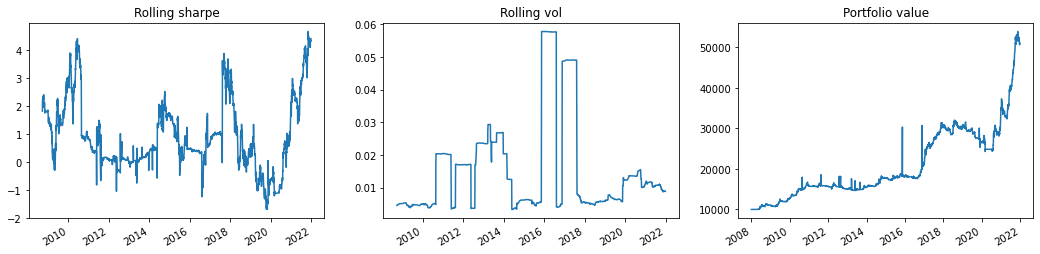

In [23]:
pref_result = stat.show_rolling_stats(result, 180)

/home/qavi/trading/zipline-technical-analysis/strategy/moving_average.py:20: RuntimeWarning: invalid value encountered in double_scalars
  ER = [signal[i]/noise[i] for i in range(len(signal))]
/home/qavi/trading/zipline-technical-analysis/strategy/moving_average.py:20: RuntimeWarning: invalid value encountered in double_scalars
  ER = [signal[i]/noise[i] for i in range(len(signal))]
/home/qavi/trading/zipline-technical-analysis/strategy/moving_average.py:20: RuntimeWarning: invalid value encountered in double_scalars
  ER = [signal[i]/noise[i] for i in range(len(signal))]


Buycount:103, Sellcount:18


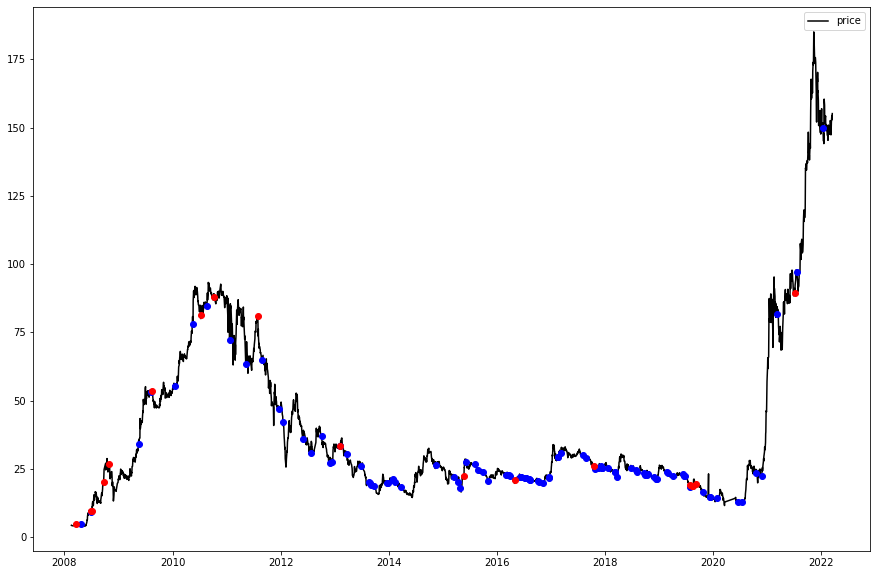

In [42]:
slist = signal_generator('BEXIMCO', rsitype=3, rsi_window=3, rsi_diff=5/10000)
signals_plot(slist, signal="RSI")

In [44]:
sig = -1
slist.loc[((slist.keltner==sig) | (slist.macd ==sig)) & (slist.RSI==sig)]

,close,keltner,RSI,macd,gradient,signal,ER
timestamp,,,,,,,
2008-05-14 00:00:00+00:00,4.23,1,-1,-1,0,0,-0.466667
2010-07-04 00:00:00+00:00,82.64,1,-1,-1,0,0,-0.827451
2010-07-15 00:00:00+00:00,81.21,1,-1,-1,0,0,0.209139
2010-10-05 00:00:00+00:00,87.82,0,-1,-1,0,-1,0.257143
2011-12-11 00:00:00+00:00,47.13,1,-1,-1,0,0,-0.678670
2012-05-20 00:00:00+00:00,40.49,1,-1,-1,0,0,-0.932836
2012-07-17 00:00:00+00:00,30.62,1,-1,-1,0,0,-0.419643
2012-11-01 00:00:00+00:00,33.19,1,-1,-1,0,0,-0.478261
2013-08-12 00:00:00+00:00,20.16,1,-1,-1,0,0,-0.025157


# Combining RSI+Keltner+MACD

In [47]:
%%capture kltr
start = '2008-01-01'
end = '2022-01-01'
capital_base = 10000
calendar = get_calendar('XDSE')
window = 90

def initialize(context):
            context.i = 0
            #set_benchmark(symbol(symb))
            sids = bundle_data.asset_finder.sids
            context.assets = bundle_data.asset_finder.retrieve_all(sids)
            context.signals = {}
            for asset in context.assets:
                if asset.symbol in prefs:
                    # signal_generator(asset.symbol, keltner_window=window, ma_long=40, ma_short=4, ad_window=4, rsitype=1, downmult=0.8, upmult=0.8, gradient_window=30)
                    slist = signal_generator(asset.symbol, keltner_window=90, ma_long=40, ma_short=4, ad_window=10, rsitype=2, rsi_window=2, rsi_diff=5/10000)
                    signals = slist[['keltner', 'RSI', 'macd']].sum(axis=1)
                    buys = [1 if ((slist.keltner[i]>0) | (slist.macd[i]>0)) & (slist.RSI[i]>0) else 0 for i in range(len(signals))]
                    sells = [-1 if ((slist.keltner[i]<0) | (slist.macd[i]<0)) & (slist.RSI[i]<0) else 0 for i in range(len(signals))]
                    context.signals[asset.symbol] = pd.Series([b+s for b,s in zip(buys,sells)], index=slist.index)
            context.i = 0

def handle_data(context, data):
    # Skip first 300 days to get full windows
    context.i += 1
    if context.i < window+1:
        return

    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    #cash = min(context.portfolio.cash, 20000)
    current_date = data.history(context.assets[0], 'price', bar_count=2, frequency="1d").index[-1]
    for asset in context.assets:
        if asset.symbol in prefs:
            if data.can_trade(asset) and not get_open_orders(asset):
                cash = context.portfolio.cash
                price = data.current(asset, "price")
                # Find corresponding signal
                #open_orders = get_open_orders()
                if context.signals[asset.symbol][current_date]>=1:
                    # 1 signal means upward trend
                    order_target_percent(asset, 0.1)
                elif context.signals[asset.symbol][current_date]<=-1:
                    # Assume downward trend and sell off
                    order_target(asset, 0)
                else:
                    pass


    
    

result = run_algorithm(start=pd.Timestamp(start, tz='utc'),
                        end=pd.Timestamp(end, tz='utc'),
                        initialize=initialize,
                        handle_data=handle_data,
                        capital_base=capital_base,
                        trading_calendar=calendar,
                        bundle='dsebundle',
                        data_frequency='daily',
                        )

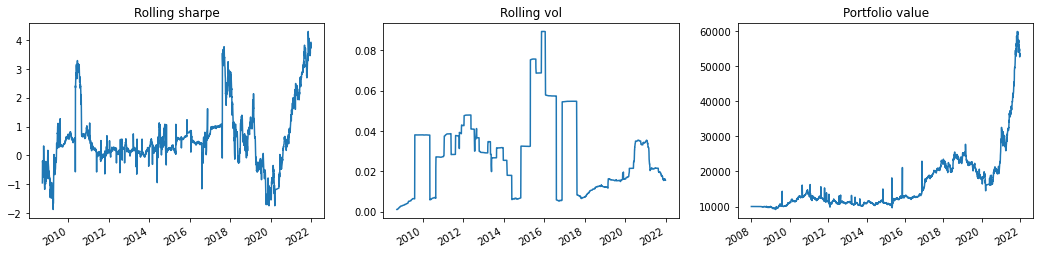

In [48]:
pref_result = stat.show_rolling_stats(result, 180)

In [8]:
%%capture kltr
start = '2008-01-01'
end = '2022-01-01'
capital_base = 10000
calendar = get_calendar('XDSE')
window = 90

def initialize(context):
            context.i = 0
            #set_benchmark(symbol(symb))
            sids = bundle_data.asset_finder.sids
            context.assets = bundle_data.asset_finder.retrieve_all(sids)
            context.signals = {}
            for asset in context.assets:
                if asset.symbol in prefs:
                    # signal_generator(asset.symbol, keltner_window=window, ma_long=40, ma_short=4, ad_window=4, rsitype=1, downmult=0.8, upmult=0.8, gradient_window=30)
                    slist = signal_generator(asset.symbol, keltner_window=90, ma_long=40, ma_short=4, ad_window=10, rsitype=2, rsi_window=2, rsi_diff=5/10000)
                    signals = slist[['keltner', 'RSI', 'macd']].sum(axis=1)
                    buys = [1 if ((slist.keltner[i]>0) | (slist.macd[i]>0)) | (slist.RSI[i]>0) else 0 for i in range(len(signals))]
                    sells = [-1 if ((slist.keltner[i]<0) | (slist.macd[i]<0)) | (slist.RSI[i]<0) else 0 for i in range(len(signals))]
                    context.signals[asset.symbol] = pd.Series([b+s for b,s in zip(buys,sells)], index=slist.index)
            context.i = 0

def handle_data(context, data):
    # Skip first 300 days to get full windows
    context.i += 1
    if context.i < window+1:
        return

    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    #cash = min(context.portfolio.cash, 20000)
    current_date = data.history(context.assets[0], 'price', bar_count=2, frequency="1d").index[-1]
    for asset in context.assets:
        if asset.symbol in prefs:
            if data.can_trade(asset) and not get_open_orders(asset):
                cash = context.portfolio.cash
                price = data.current(asset, "price")
                # Find corresponding signal
                #open_orders = get_open_orders()
                if context.signals[asset.symbol][current_date]>=1:
                    # 1 signal means upward trend
                    order_target_percent(asset, 0.1)
                elif context.signals[asset.symbol][current_date]<=-1:
                    # Assume downward trend and sell off
                    order_target(asset, 0)
                else:
                    pass


    
    

result = run_algorithm(start=pd.Timestamp(start, tz='utc'),
                        end=pd.Timestamp(end, tz='utc'),
                        initialize=initialize,
                        handle_data=handle_data,
                        capital_base=capital_base,
                        trading_calendar=calendar,
                        bundle='dsebundle',
                        data_frequency='daily',
                        )

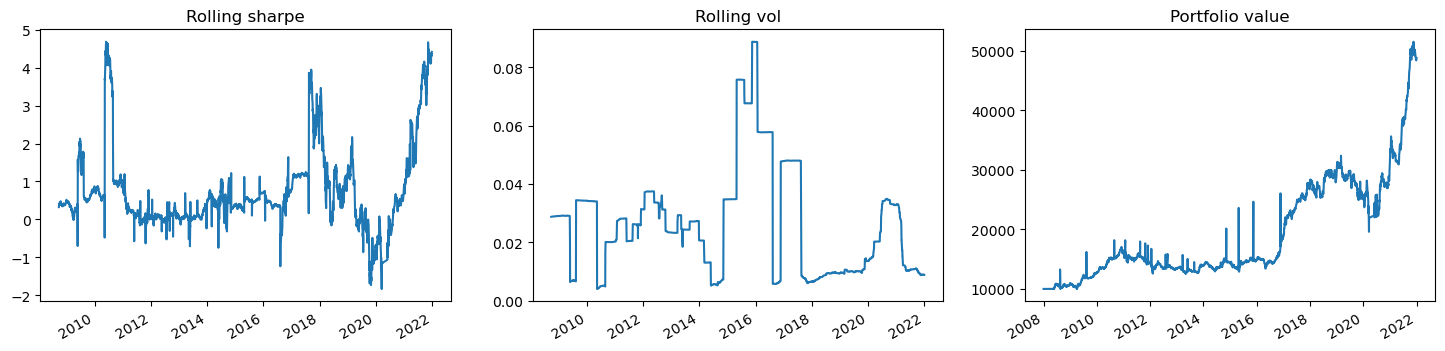

In [10]:
%matplotlib inline
pref_result = stat.show_rolling_stats(result, 180)